# 基本設定

In [1]:
import setting

import pandas as pd
import numpy as np
import math
import pathlib as Path

import scipy as sc
import sklearn
import pickle
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sb
sb.set(font='IPAexGothic')

# データ格納先設定
data_path = Path.Path('../data')
# 接頭辞
prefix = 'ana501'

# データ抽出

In [2]:
# 分析データ
_df = pd.read_pickle(data_path / 'ana400_ana.pkl')

# データの分割

In [3]:
ana = _df.set_index('customer_id_nys').copy()

In [4]:
# 訓練用データ
df_train = ana[ana['flg_train'] == 1]
# テストデータ
df_test = ana[ana['flg_train'] == 0]

# モデル構築
> モデル：ロジスティック回帰モデル\
> 推定：最尤法\
> ハイパラ探索：CV

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score

## モデル推定

In [6]:
# ハイパラ設定
pram_grid = {
    
    'penalty':['l2'],
    'C':[10**i for i in range(-2, 3)],
    'max_iter':[100],
    'random_state':[123]
    
}

In [7]:
# ロジスティック回帰
model = GridSearchCV(
    LogisticRegression(),
    pram_grid,
    # 分割数：10
    cv=10
)

In [8]:
# 推定
model.fit(
    # 説明変数（FTRから始まる変数）
    df_train.filter(like='FTR'), 
    # 目的変数
    df_train['flg_sts']
)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'max_iter': [100],
                         'penalty': ['l2'], 'random_state': [123]})

## モデル式

In [9]:
# 探索内ベストモデル
model_best = model.best_estimator_

In [10]:
# 変数と係数の確認
lst_model = pd.concat(
    
    [
        # 係数
        pd.DataFrame({'ftr_name':df_train.columns[2:], 'coef':model_best.coef_[0]}),
        
        # 切片
        pd.DataFrame({'ftr_name':'Intercept', 'coef':model_best.intercept_})
        
    ]
    
)

### 可視化

<BarContainer object of 109 artists>

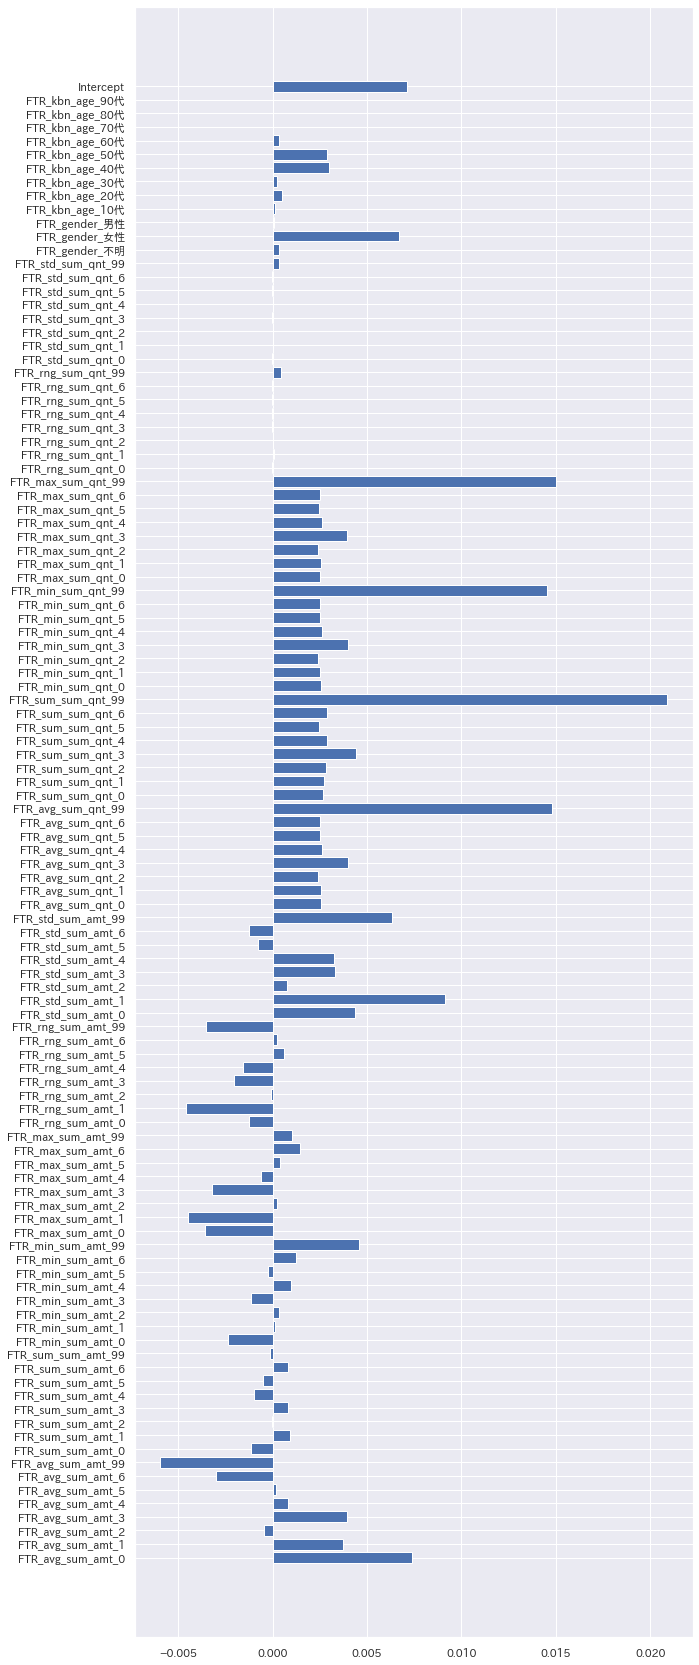

In [11]:
fig = plt.figure(figsize=(10, 30))
plt.barh(lst_model['ftr_name'], lst_model['coef'])

### 出力

In [12]:
# モデルリストの出力
lst_model.to_csv(data_path / ('%s_lst_model.csv' % prefix))

# 係数の可視化
fig.savefig(data_path / ('%s_barh_coef.png' % prefix))

## スコア計算

In [13]:
_scr = pd.DataFrame(
    
    model_best.predict_proba(

        # モデルの説明変数のみ
        _df[lst_model[lst_model['ftr_name'] != 'Intercept']['ftr_name']]
        
    ),
    # 列名
    columns=['scr0', 'scr1']
)

In [14]:
df_scr = pd.concat([_df, _scr], axis=1)
df_scr

,customer_id_nys,flg_sts,flg_train,FTR_avg_sum_amt_0,FTR_avg_sum_amt_1,FTR_avg_sum_amt_2,FTR_avg_sum_amt_3,FTR_avg_sum_amt_4,FTR_avg_sum_amt_5,FTR_avg_sum_amt_6,...,FTR_kbn_age_20代,FTR_kbn_age_30代,FTR_kbn_age_40代,FTR_kbn_age_50代,FTR_kbn_age_60代,FTR_kbn_age_70代,FTR_kbn_age_80代,FTR_kbn_age_90代,scr0,scr1
0,CS005415000212,0,1,0.0,1164.0,356.0,357.000000,0.0,0.0,383.0,...,0,0,1,0,0,0,0,0,0.996815,0.003185
1,CS038314000063,1,1,0.0,0.0,108.0,0.000000,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0.470076,0.529924
2,CS028415000181,0,1,202.0,0.0,0.0,340.000000,0.0,0.0,1461.5,...,0,0,1,0,0,0,0,0,0.852730,0.147270
3,CS014514000027,1,1,0.0,0.0,0.0,0.000000,0.0,0.0,256.0,...,0,0,0,1,0,0,0,0,0.455328,0.544672
4,CS025215000003,0,1,383.0,0.0,0.0,974.000000,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0.715356,0.284644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3359,CS022514000068,0,0,0.0,368.0,0.0,0.000000,466.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0.464288,0.535712
3360,CS012414000086,1,0,958.0,0.0,0.0,293.000000,0.0,0.0,484.0,...,0,0,1,0,0,0,0,0,0.611711,0.388289
3361,CS023514000029,1,0,0.0,0.0,0.0,0.000000,314.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0.577660,0.422340
3362,CS025515000053,1,0,0.0,308.0,0.0,0.000000,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0.467118,0.532882


## 評価（AR）

In [15]:
df_AR = pd.concat(
    
    [
        # 訓練用、テストデータ
        df_scr.groupby('flg_train').apply(lambda x : roc_auc_score(x['flg_sts'], x['scr1'])).to_frame().rename(columns={0:'AR値'}),
        # 全体
        pd.DataFrame({'AR値':[roc_auc_score(df_scr['flg_sts'], df_scr['scr1'])]}, index=['全体'])
        
    ], axis=0
    
)
df_AR

,AR値
0,0.747159
1,0.764405
全体,0.759303


# データ保存

In [16]:
# スコアデータ
df_scr.to_pickle(data_path / ('%s_ana_scr.pkl' % prefix))

# AR値
df_AR.to_pickle(data_path / ('%s_AR.pkl' % prefix))